# WS 10 Performancevergleiche Regression

* Vergleichen Sie alle Regressoren (ausser `SVR` und `MLPRegressor`) mit folgenden Modifikationen
  * die Vergleiche werden ohne und mit Standardisierung der Features durchgeführt
  * die Resultate (r2_score) werden in Form einer Heatmap zusammengestellt
* informieren Sie sich zum Vorgehen am Code in 3.4 Regression - Modellvergleiche.ipynb
* Präsentation der Ergebnisse als 
  * seaborn heatmap
  * alternative Visualisierung: Grouped barplots

In [3]:
## for scikit-learn 1.4.2, to silence warnings regarding physical cores
import os
os.environ['LOKY_MAX_CPU_COUNT'] = '4' ## depending on the hardware used

In [4]:
## prepare env, read and prepare data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

#codepath = '../2_code'
#datapath = '../3_data'
codepath = '.././2_code'
datapath = '../../3_data'
from sys import path; path.insert(1, codepath)
from os import chdir; chdir(datapath)

from bfh_cas_pml import prep_data
X_train, X_test, y_train, y_test = prep_data('melb_data_prep.csv', target='Price', seed=1234)

In [5]:
## standardize features (lead: train)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [6]:
## import trainer classes
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor

from sklearn.metrics import r2_score

In [7]:
## define models
models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    KNeighborsRegressor(),
    DecisionTreeRegressor(max_depth=8),
    RandomForestRegressor(random_state = 1234),
    AdaBoostRegressor(DecisionTreeRegressor(max_depth=15), learning_rate=0.07),
    GradientBoostingRegressor(),
    HistGradientBoostingRegressor(),
    CatBoostRegressor(logging_level='Silent'),
    LGBMRegressor()
]

In [8]:
## compare models
regressors = []
r2_nos = []
r2_yess = []

print('Regressor                        r2_no       r2_yes')
print('=====================================================')

for model in models:
    name = model.__class__.__name__ 
    regressors.append(name)

    ## not scaled
    model.fit(X_train, y_train)     
    y_pred = model.predict(X_test)  
    r2_no = r2_score(y_test, y_pred)   
    r2_nos.append(r2_no)
    
    ## scaled
    model.fit(X_train_sc, y_train)     
    y_pred = model.predict(X_test_sc)  
    r2_yes = r2_score(y_test, y_pred)   
    r2_yess.append(r2_yes)

    print('%-30s   %0.6f    %0.6f' %(name, r2_no, r2_yes)) ## console output
    

Regressor                        r2_no       r2_yes
LinearRegression                 0.560142    0.560142
Ridge                            0.560139    0.560142
Lasso                            0.560143    0.560142
KNeighborsRegressor              0.449957    0.629232
DecisionTreeRegressor            0.671175    0.673623
RandomForestRegressor            0.777948    0.778405
AdaBoostRegressor                0.766560    0.765674
GradientBoostingRegressor        0.724983    0.726858
HistGradientBoostingRegressor    0.786575    0.784661
CatBoostRegressor                0.800349    0.799714
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1630
[LightGBM] [Info] Number of data points in the train set: 12262, number of used features: 23
[LightGBM] [Info] Start training from score 1055902.695237
[LightGBM] [Info] Auto-choosing row-wise multi-threading, th

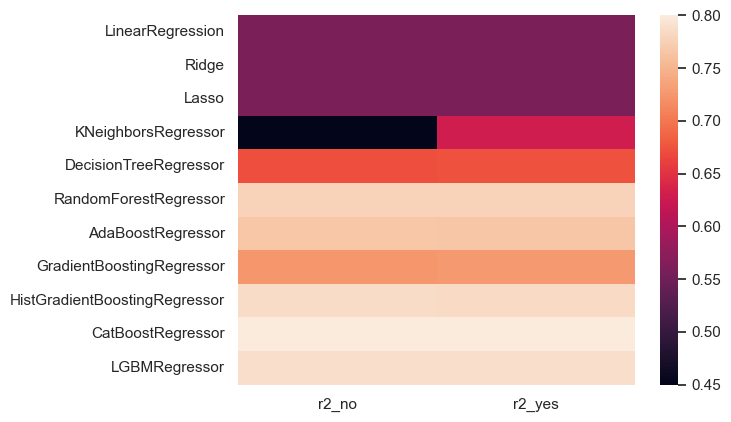

In [9]:
## visualize results
scores = pd.DataFrame(
    {'r2_no': r2_nos, 
     'r2_yes': r2_yess
    }, index=regressors)

sns.heatmap(scores);

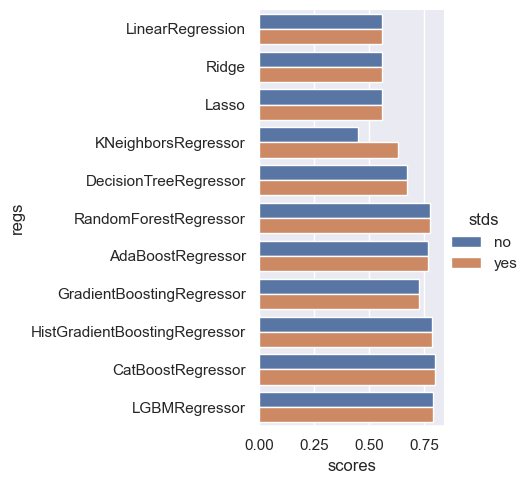

In [10]:
## alternative visualization: grouped catplot
scores_df = pd.DataFrame({
    'regs' : regressors + regressors,
    'scores' : r2_nos + r2_yess,
    'stds' : ['no' for i in range(len(regressors))] + ['yes' for i in range(len(regressors))]
})

sns.catplot(
    data=scores_df,
    kind='bar',
    y="regs", 
    x="scores", 
    hue="stds"#,
);

**Fazit:**

* Unterschiede in der Performance bei Standardisieren zeigen sich bei
  * markante Verbesserung bei KNeighborsRegressor
  * marginale Verbesserungen bei
    * AdaBoostRegressor
    * GradientBoostingRegressor
    * HistGradientBoostingRegressor
* im übrigen kaum Unterschiede